In [1]:
import numpy as np
import hickle as hkl
%run ../../src/preprocessing/whittaker_smoother.py
%run ../../src/preprocessing/cloud_removal.py
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange, tqdm_notebook

ModuleNotFoundError: No module named 'src'

In [38]:
def initialize_smoother(lmbd: int = 800, dim = 29) -> np.ndarray:
    diagonals = np.zeros(2*2+1)
    diagonals[2] = 1.
    for i in range(2):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(2+1)
    shape = (dim - 2, dim)
    E = sparse.eye(dim, format = 'csc')
    D = scipy.sparse.diags(diagonals, offsets, shape)
    D = D.conj().T.dot(D) * lmbd
    coefmat = E + D
    splu_coef = splu(coefmat)
    return splu_coef

def smooth(y: np.ndarray, splu_coef: np.ndarray = splu_coef) -> np.ndarray:
    ''' 
    Apply whittaker smoothing to a 1-dimensional array, returning a 1-dimensional array
    '''
    return splu_coef.solve(np.array(y))

In [9]:
post = hkl.load("../../tile_data/guatemala-gain-2/2019/raw/s2/processed_0_0.hkl")
x = hkl.load("../../tile_data/guatemala-gain-2/2019/raw/s2/0_0.hkl")

In [91]:
interp = hkl.load("../../tile_data/elsalvador-imposible/raw/s2/interp_1_1.hkl")

In [14]:
clouds = hkl.load("../../tile_data/guatemala-gain-2/2019/raw/clouds/clouds_0_0.hkl")
np.mean(clouds, axis = (1, 2))

array([0.0099998 , 0.15962696, 0.04189912, 0.1046284 , 0.0344484 ,
       0.03860093, 0.01103312, 0.1912981 , 0.06588495, 0.15715227,
       0.06992064, 0.04237074, 0.02678924, 0.16167266, 0.18935973,
       0.06096848, 0.04618496, 0.04238769, 0.01513738, 0.02257939,
       0.03393801, 0.00853561, 0.09860465, 0.01737521, 0.03603345,
       0.16771536, 0.01822226, 0.20224508, 0.18171919])

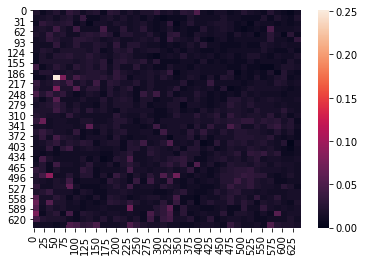

In [141]:
sns.heatmap(clouds[17])

In [191]:
post.shape

(30, 646, 646, 10)

In [650]:
np.mean(interp, axis = (1, 2, 3))

array([0.06727037, 0.52648592, 0.78526105, 0.31273184, 0.00758178,
       0.        , 0.42005339, 0.25724631, 0.16901581, 0.        ,
       0.04436446, 0.01723634, 0.42888602, 0.1824924 , 0.20231192,
       0.1891684 , 0.        , 0.12205858, 0.22163061, 0.03898485,
       0.40600648, 0.24608929, 0.36984443, 0.13909603])

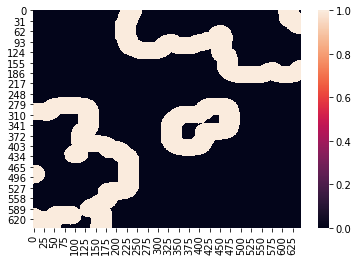

In [563]:
import math
from scipy.ndimage import distance_transform_edt as distance
def calc_dist_map(seg):
    '''Utility function for calc_dist_map_batch that calculates the loss
       importance per pixel based on the surface distance function
    
         Parameters:
          seg (arr):
          
         Returns:
          res (arr):
    '''
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        
    res[np.where(res == 0)] = 1
    res[np.where(res > 25)] = 0
    res[np.where(res < -25)] = 0
    res[np.where(res != 0)] = 1
    return res

dmap = calc_dist_map(interp[4, :, :, 0])

sns.heatmap(dmap)

In [564]:
from scipy.interpolate import RegularGridInterpolator
z = np.copy(post[5, :, :, 0])
post2 = np.copy(post[5, :, :, 0])
z[np.where(dmap == 0)] = np.nan
x = np.arange(0, 646, 1)
y = np.arange(0, 646, 1)
zinterp = RegularGridInterpolator((x, y), z.T)

# new grid to interpolate on
X2, Y2 = np.meshgrid(x, y)
newpoints = np.array((X2, Y2)).T

# actual interpolation
z2 = zinterp(newpoints)
z2_masked = np.ma.array(z2, mask=np.isnan(z2))

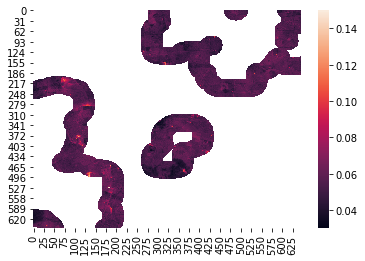

In [565]:
sns.heatmap(z2_masked, vmax = 0.15)

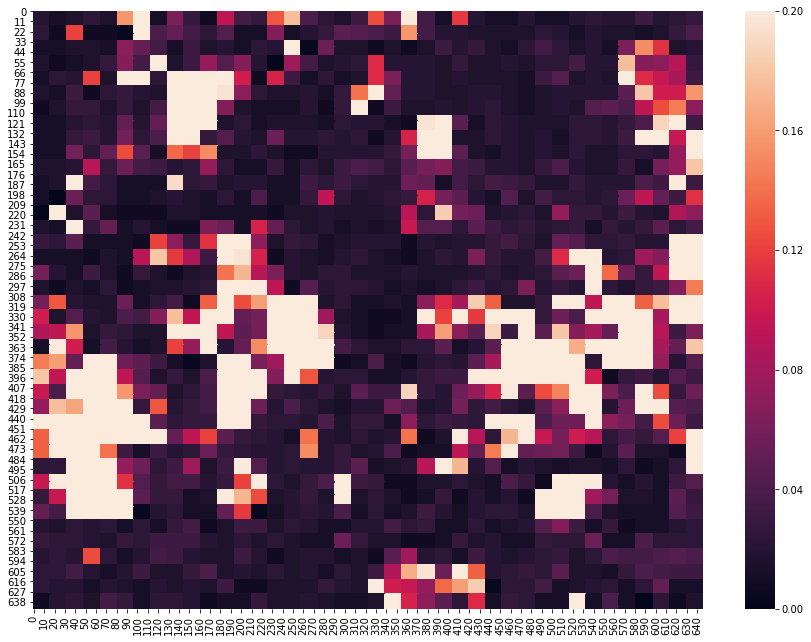

In [22]:
plt.figure(figsize=(15, 11))
sns.heatmap(clouds[3, :, :], vmax = 0.2)

In [23]:
plt.figure(figsize=(15, 11))
sns.heatmap(x[3, :, :, 0], vmax = 0.2)

In [20]:
plt.figure(figsize=(15, 11))
sns.heatmap(post[-3, :, :, 0], vmax = 0.2)

In [142]:
def remove_missed_clouds(img: np.ndarray) -> np.ndarray:
    """ Removes clouds that may have been missed by s2cloudless
        by looking at a temporal change outside of IQR
        
        Parameters:
         img (arr): 
    
        Returns:
         to_remove (arr): 
    """
    iqr = np.percentile(img[..., 0].flatten(), 75) - np.percentile(img[..., 0].flatten(), 25)
    thresh_t = np.percentile(img[..., 0].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[..., 0].flatten(), 25) - iqr*2
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, ..., 0].flatten() > thresh_t))
        top = len(np.argwhere(img[step, ..., 0].flatten() < thresh_b))
        p = 100 * ((bottom + top) / (img.shape[1]*img.shape[2]))
        outlier_percs.append(p)
    print([int(x) for x in outlier_percs])
    to_remove = np.argwhere(np.array(outlier_percs) > 15)
    return to_remove

remove_missed_clouds(x)


[0, 0, 5, 0, 0, 0, 0, 100, 97, 0, 100, 0, 0, 8, 0, 9, 100, 0, 2, 21, 33, 0, 76, 0, 80, 52, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15]


array([[ 7],
       [ 8],
       [10],
       [16],
       [19],
       [20],
       [22],
       [24],
       [25],
       [26]])

In [ ]:
# 2, 9, 10, 11, 13, 14, 16, 17, 21

In [187]:
plt.figure(figsize=(12, 8))
sns.heatmap(post[19, :, :, 0], vmax = 0.3) # 10, 11, 15

IndexError: index 19 is out of bounds for axis 0 with size 19

<Figure size 864x576 with 0 Axes>

In [470]:
def adjust_interpolated_areas(array, interp):
    for time in range(array.shape[0]):
        for band in range(array.shape[-1]):
            interp_i = interp[time, :, :, band]
            array_i = array[time, :, :, band]
            if np.sum(interp_i) > 0:
                adj = (np.median(array_i[np.where(interp_i == 0)]) - 
                      (np.median(array_i[np.where(interp_i == 1)])))
                print(f"Adjusting {time} and {band} by {adj}")
                array_i[np.where(interp_i == 1)] += adj
                array[time, :, :, band] = array_i
    return array

0.009628442816815422


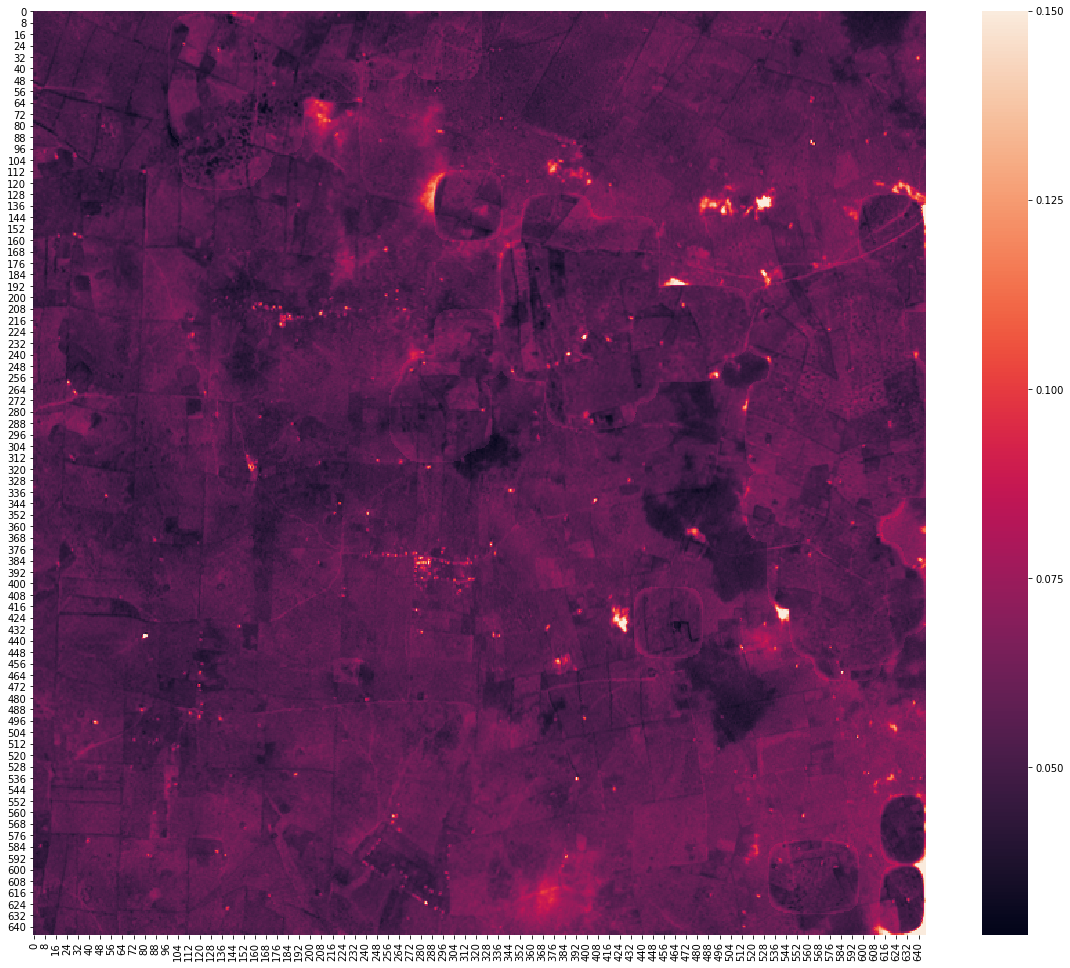

In [452]:
plt.figure(figsize=(20, 17))
interp_4 = interp[5, :, :, 0]
post_4 = post[5, :, :, 0]
adj = (np.median(post_4[np.where(interp_4 == 0)]) - 
           (np.median(post_4[np.where(interp_4 == 1)])))
print(adj)
post_4[np.where(interp_4 == 1)] += adj
sns.heatmap(post_4, vmax = 0.15)

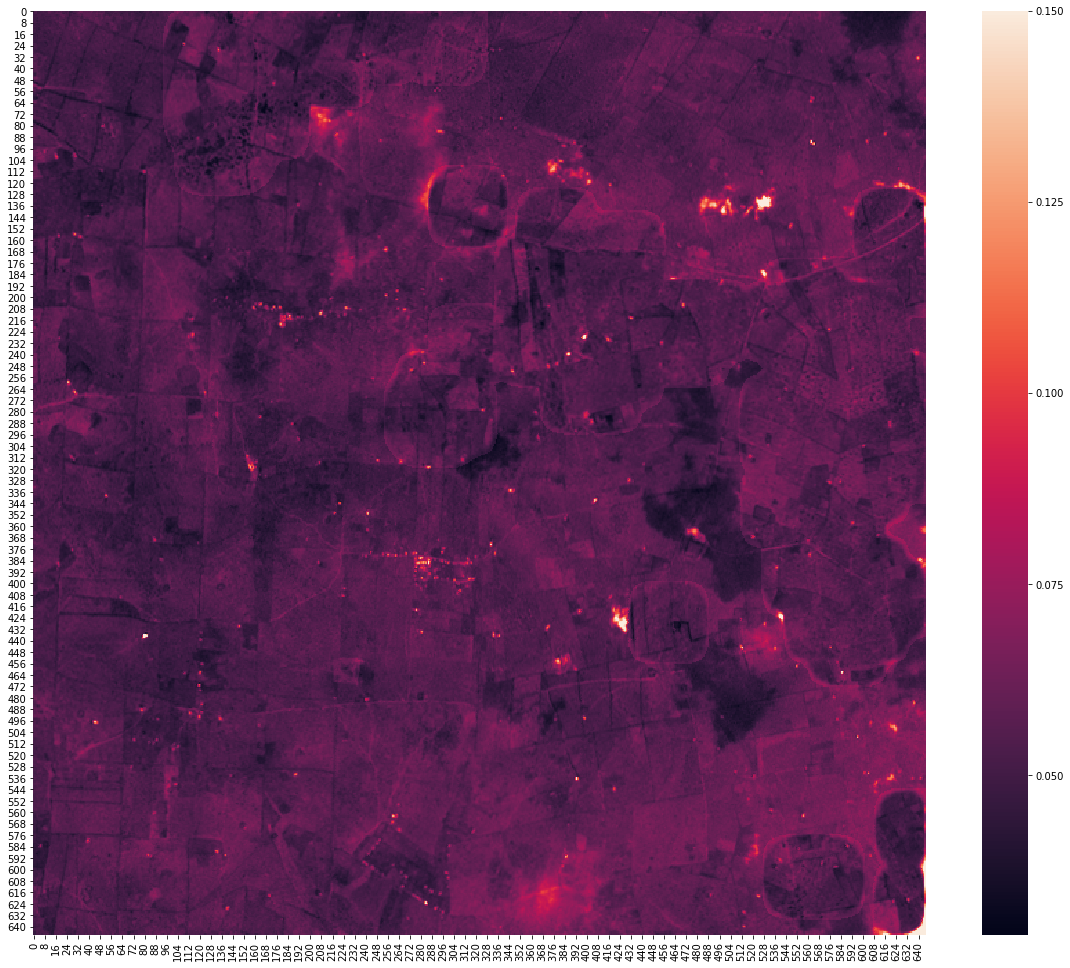

In [477]:
plt.figure(figsize=(20, 17))
sns.heatmap(post[5, :, :, 0], vmax = 0.15)

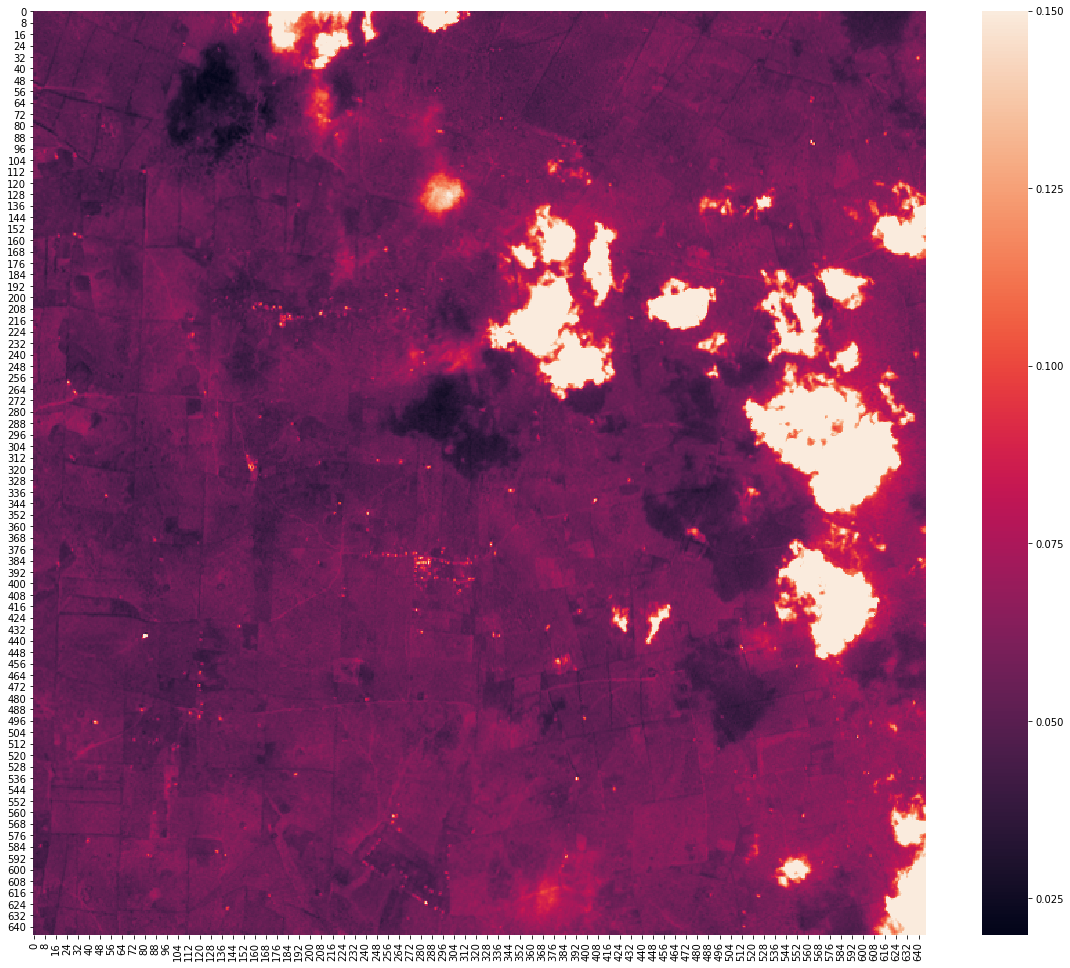

In [451]:
plt.figure(figsize=(20, 17))
sns.heatmap(x[5, :, :, 0], vmax = 0.15)

In [463]:
def reject_outliers(data_in, m = 2):
    data = np.copy(data_in)
    d = data - np.median(data, axis = (0))
    mdev = np.median(data, axis = 0)
    s = d / mdev
    n_changed = 0
    for x in tnrange(data.shape[1]):
        for y in range(data.shape[2]):
            for band in range(data.shape[3]):
                to_correct = np.where(s[:, x, y, band] > m) 
                data[to_correct, x, y, band] = mdev[x, y, band]
                n_changed += len(to_correct[0])
    print(f"Rejected {n_changed} outliers")
    return data

def remove_outliers(array):
    for x_window in range(0, array.shape[1], 10):
        for y_window in range(0, array.shape[2], 10):
            for band in range(0, array.shape[3], 1):
                local_min = x
                local_max = y
                
    return array

In [473]:
#post = adjust_interpolated_areas(post, interp)
data = reject_outliers(post)


Rejected 7145 outliers


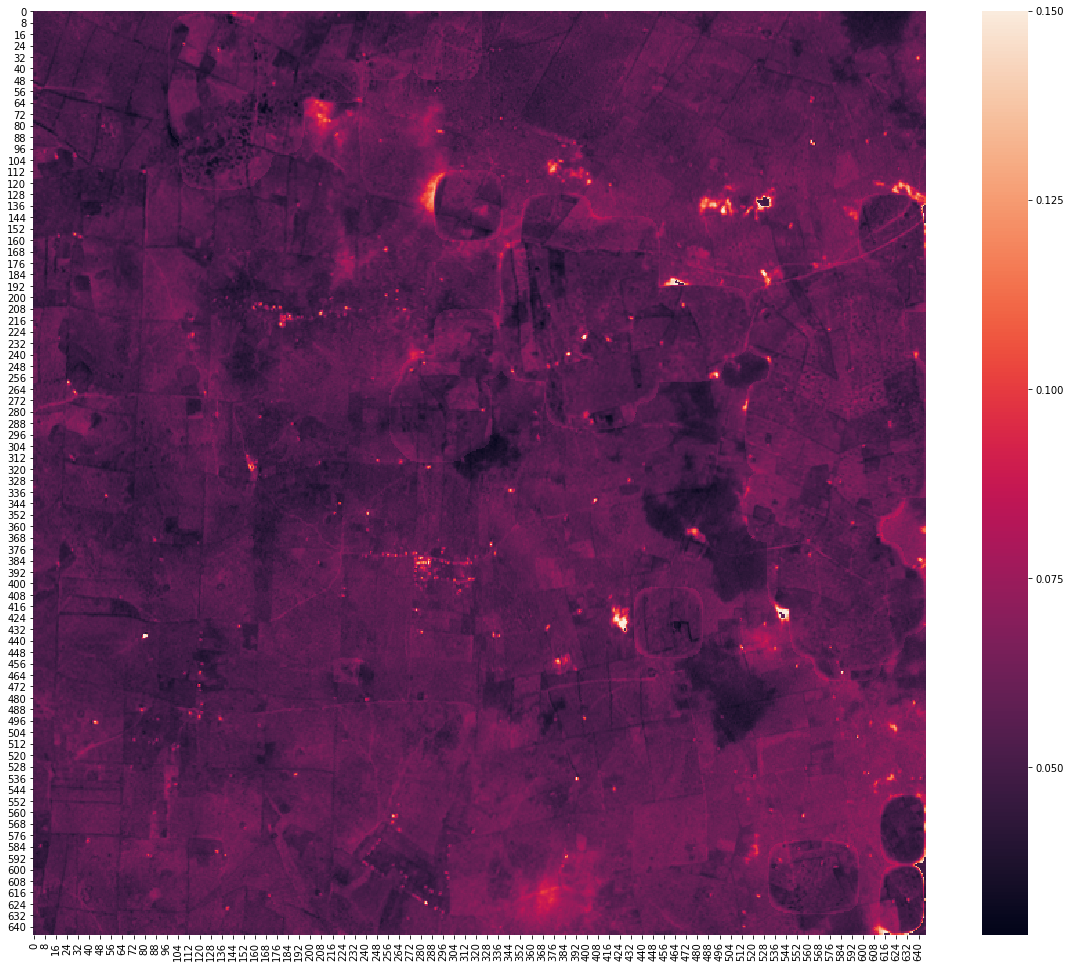

In [474]:
plt.figure(figsize=(20, 17))
sns.heatmap(data[5, :, :, 0], vmax = 0.15)

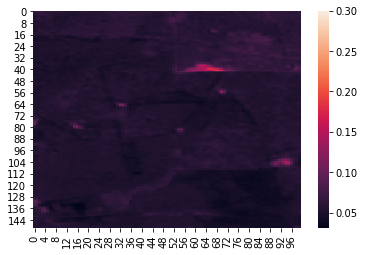

In [475]:
sns.heatmap(post[5, 150:300, 400:500, 0], vmax = 0.3)

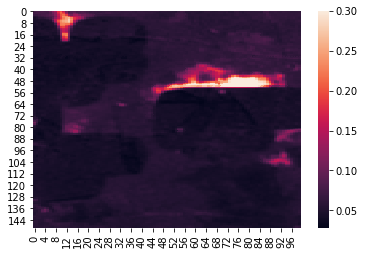

In [353]:
sns.heatmap(post[5, 150:300, 400:500, 0], vmax = 0.3)

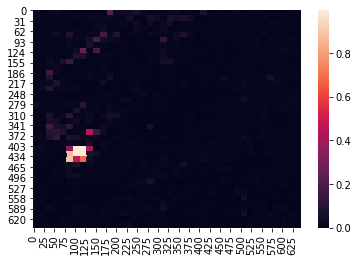

In [301]:
sns.heatmap(clouds[-3])

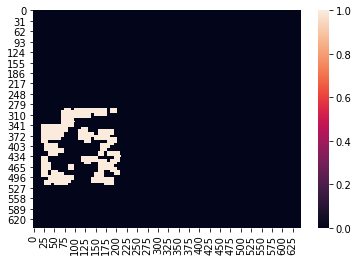

In [300]:
shadows = hkl.load("../../tile_data/guatemala-gain-2/2019/raw/clouds/shadows_0_0.hkl")
sns.heatmap(shadows[-3])

In [193]:
sns.heatmap(x[-3, :, :, 4])

(0.15, 0.5)

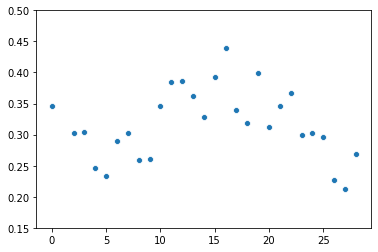

In [119]:
before_smooth = x[:, 115, 39, 3]
sns.scatterplot([x for x in range(x.shape[0])], before_smooth)
plt.ylim(0.15, 0.5)

In [124]:
def initialize_smoother(lmbd: int = 800, dim = 29) -> np.ndarray:
    diagonals = np.zeros(2*2+1)
    diagonals[2] = 1.
    for i in range(2):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(2+1)
    shape = (dim - 2, dim)
    E = sparse.eye(dim, format = 'csc')
    D = scipy.sparse.diags(diagonals, offsets, shape)
    D = D.conj().T.dot(D) * lmbd
    coefmat = E + D
    splu_coef = splu(coefmat)
    return splu_coef

def smooth(y: np.ndarray, splu_coef: np.ndarray = splu_coef) -> np.ndarray:
    ''' 
    Apply whittaker smoothing to a 1-dimensional array, returning a 1-dimensional array
    '''
    return splu_coef.solve(np.array(y))

splu_coef = initialize_smoother(800, int(x.shape[0]))
smoothed = smooth(before_smooth)

(0.15, 0.5)

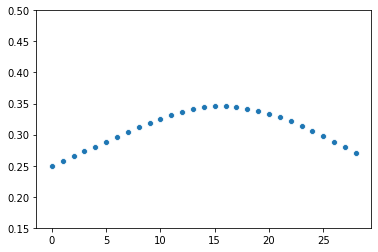

In [125]:
sns.scatterplot([x for x in range(x.shape[0])], smoothed)
plt.ylim(0.15, 0.5)

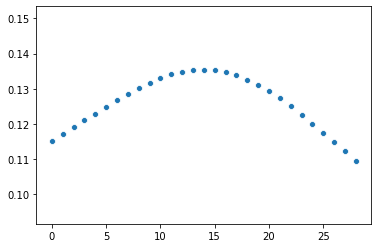

In [189]:
smoothed = smooth(fixed)
sns.scatterplot([x for x in range(x.shape[0])], smoothed)
#plt.ylim(0.17, 0.4)